# Topic Classification
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

Device count: 1
Current device: 0
NVIDIA GeForce RTX 3090


In [3]:
data_path = "./data/"
train_zip = data_path + "bbc-train.zip"
test_zip = data_path + "bbc-test.zip"

train_path = data_path + "bbc-train"
test_path= data_path + "bbc-test"

In [4]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [5]:
# Unzip data files
import os
import zipfile

if not os.path.exists(train_path):
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Unzipped train data")

if not os.path.exists(test_path):
    with zipfile.ZipFile(test_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Unzipped test data")

### Train data

In [6]:
class_names = sorted(x for x in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, x)))
num_class = len(class_names)
train_files = [
    [os.path.join(train_path, class_names[i], x) for x in os.listdir(os.path.join(train_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(train_files[i]) for i in range(num_class)]
train_files_list = []
train_classes = []
for i in range(num_class):
    train_files_list.extend(train_files[i])
    train_classes.extend([i] * num_each[i])
num_total = len(train_classes)

print(f"Number of train documents: {num_total}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Number of train documents: 2015
Label names: ['business', 'entertainment', 'politics', 'sports', 'tech']
Label counts: [460, 356, 377, 461, 361]


### Test data

In [7]:
test_files = [
    [os.path.join(test_path, class_names[i], x) for x in os.listdir(os.path.join(test_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(test_files[i]) for i in range(num_class)]
test_files_list = []
test_classes = []
for i in range(num_class):
    test_files_list.extend(test_files[i])
    test_classes.extend([i] * num_each[i])
num_total = len(test_classes)

print(f"Number of test documents: {num_total}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Number of test documents: 210
Label names: ['business', 'entertainment', 'politics', 'sports', 'tech']
Label counts: [50, 30, 40, 50, 40]


Train data: 90.56%
Test data: 9.44%


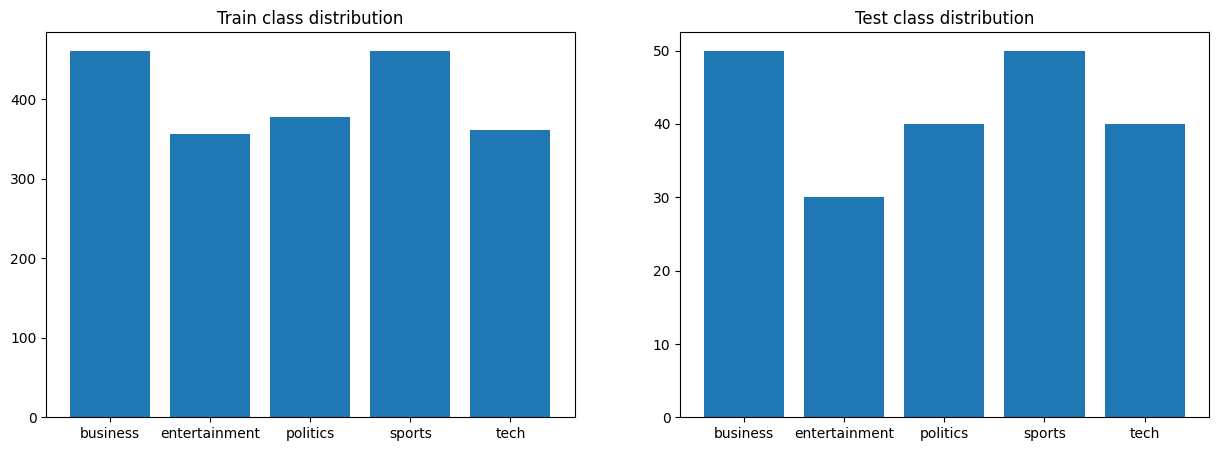

In [8]:
# Percentage of test and train data
train_percent = len(train_files_list) / (len(train_files_list) + len(test_files_list))
test_percent = len(test_files_list) / (len(train_files_list) + len(test_files_list))
print(f"Train data: {train_percent * 100:.2f}%")
print(f"Test data: {test_percent * 100:.2f}%")

# Plot class distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(class_names, [len(train_files[i]) for i in range(num_class)])
plt.title("Train class distribution")
plt.subplot(1, 2, 2)
plt.bar(class_names, [len(test_files[i]) for i in range(num_class)])
plt.title("Test class distribution")
plt.show()

In [9]:
# Read example train file
print("File name:", train_files_list[0])
print()
with open(train_files_list[0], "r") as f:
    print(f.read())

File name: ./data/bbc-train/business/461.txt

Beijingers fume over parking fees

Choking traffic jams in Beijing are prompting officials to look at reorganising car parking charges.

Car ownership has risen fast in recent years, and there are now two and a half million cars on the city's roads. The trouble is that the high status of car ownership is matched by expensive fees at indoor car parks, making motorists reluctant to use them. Instead roads are being clogged by drivers circling in search of a cheaper outdoor option. "The price differences between indoor and outdoor lots are unreasonable," said Wang Yan, an official from the Beijing Municipal Commission for Development and Reform quoted in the state-run China Daily newspaper. Mr Wang, who is in charge of collecting car parking fees, said his team would be looking at adjusting parking prices to close the gap. Indoor parking bays can cost up to 250% more than outdoor ones.

Sports fans who drive to matches may also find themselves

In [10]:
train_texts = []
train_labels = []
train_ids = []
for file in train_files_list:
    with open(file, "r") as f:
        try:
            text = f.read()
            train_texts.append(text)
            label = file.split("/")[-2]
            train_labels.append(class_names.index(label))
            train_ids.append(file.split("/")[-1])
        except:
            print("Error reading file:", file)

test_texts = []
test_labels = []
test_ids = []
for file in test_files_list:
    with open(file, "r") as f:
        try:
            text = f.read()
            test_texts.append(text)
            label = file.split("/")[-2]
            test_labels.append(class_names.index(label))
            test_ids.append(file.split("/")[-1])
        except:
            print("Error reading file:", file)

train_df = pd.DataFrame({"id": train_ids, "text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"id": test_ids, "text": test_texts, "label": test_labels})

Error reading file: ./data/bbc-train/sports/199.txt


In [11]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014 entries, 0 to 2013
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2014 non-null   object
 1   text    2014 non-null   object
 2   label   2014 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 47.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      210 non-null    object
 1   text    210 non-null    object
 2   label   210 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


In [12]:
train_df["label"].value_counts()

label
0    460
3    460
2    377
4    361
1    356
Name: count, dtype: int64

In [13]:
test_df["label"].value_counts()

label
0    50
3    50
2    40
4    40
1    30
Name: count, dtype: int64

In [14]:
raw_datasets = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Split dataset into train and test
raw_datasets = raw_datasets.train_test_split(test_size=0.2, shuffle=True, seed=seed)

# Rename test to validation
raw_datasets["validation"] = raw_datasets["test"]
del raw_datasets["test"]

# Add test dataset
raw_datasets["test"] = test_dataset
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 1611
    })
    validation: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 403
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 210
    })
})


In [15]:
MODEL_NAME = "google-bert/bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_class)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

# Tokenize dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1611 [00:00<?, ? examples/s]

Map:   0%|          | 0/403 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

In [17]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1611
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 403
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 210
    })
})


In [18]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google-bert/bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [19]:
# Model labels
labels = model.config.id2label
print(labels)

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4'}


In [20]:
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'text'])
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1611
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 403
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 210
    })
})

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
val_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))
print("Test dataloader length:", len(test_dataloader))

Train dataloader length: 202
Validation dataloader length: 51
Test dataloader length: 27


In [22]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 399]),
 'token_type_ids': torch.Size([8, 399]),
 'attention_mask': torch.Size([8, 399]),
 'labels': torch.Size([8])}

In [23]:
from sklearn.metrics import classification_report

model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_val.extend(torch.argmax(outputs.logits, dim=-1).tolist())
        y_true_val.extend(batch["labels"].tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
print(y_pred_val.shape, y_true_val.shape)

print(classification_report(y_true_val, y_pred_val, target_names=class_names))

(403,) (403,)
               precision    recall  f1-score   support

     business       0.09      0.01      0.02        90
entertainment       0.00      0.00      0.00        69
     politics       0.00      0.00      0.00        74
       sports       0.00      0.00      0.00        89
         tech       0.20      0.98      0.33        81

     accuracy                           0.20       403
    macro avg       0.06      0.20      0.07       403
 weighted avg       0.06      0.20      0.07       403



/home/dcaballero/miniconda3/envs/AI/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dcaballero/miniconda3/envs/AI/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dcaballero/miniconda3/envs/AI/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0], xticklabels=class_names, yticklabels=class_names)
    ax[0].set_title("Confusion Matrix")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_ylabel("True Labels")
    cm_norm = (cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]) * 100
    sns.heatmap(cm_norm, annot=True, cmap="Blues", ax=ax[1], xticklabels=class_names, yticklabels=class_names, fmt=".2f")
    ax[1].set_title("Normalized Confusion Matrix")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")
    plt.tight_layout()
    plt.show()

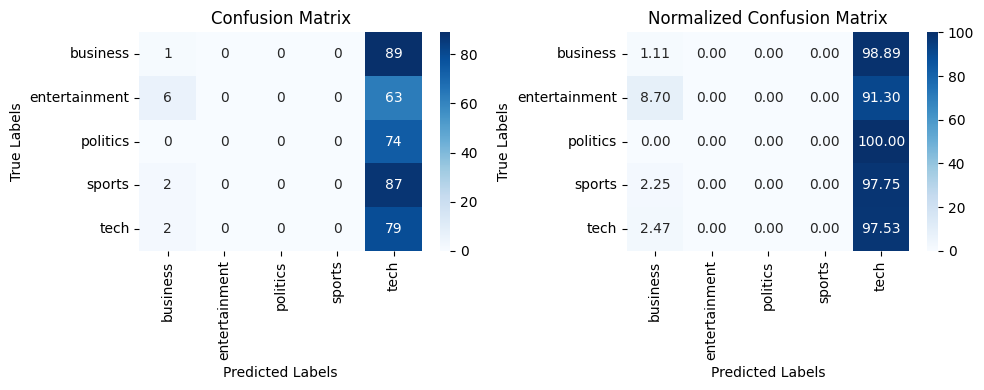

In [25]:
# Confusion matrix
plot_confusion_matrix(y_true_val, y_pred_val, class_names)

### Fine-tuning

In [171]:
from transformers import AdamW
from transformers import get_scheduler

models_path = "./models/"

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1010


/home/dcaballero/miniconda3/envs/AI/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
from tqdm.auto import tqdm

train_losses = []
val_losses = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0 
    num_train_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        num_train_batches += 1

        progress_bar.update(1)

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Run validation
    model.eval()
    epoch_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            epoch_val_loss += loss.item()
            num_val_batches += 1

    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save model
    model.save_pretrained(models_path + f"epoch_{epoch + 1}")

  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.4599, Val Loss: 0.0987
Epoch 2/5 - Train Loss: 0.0693, Val Loss: 0.1633
Epoch 3/5 - Train Loss: 0.0539, Val Loss: 0.1327
Epoch 4/5 - Train Loss: 0.0163, Val Loss: 0.0997
Epoch 5/5 - Train Loss: 0.0044, Val Loss: 0.0997


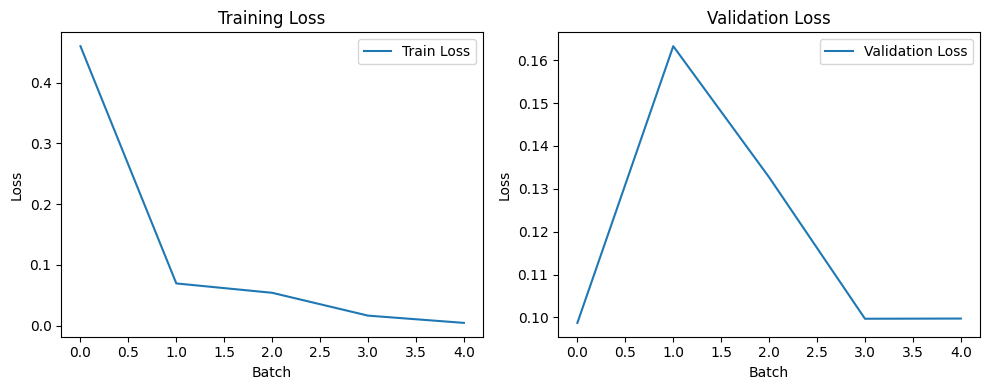

In [28]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_losses, label="Validation Loss")
plt.title("Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_val.extend(torch.argmax(outputs.logits, dim=-1).tolist())
        y_true_val.extend(batch["labels"].tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
print(y_pred_val.shape, y_true_val.shape)

print(classification_report(y_true_val, y_pred_val, target_names=class_names))

(403,) (403,)
               precision    recall  f1-score   support

     business       0.95      0.98      0.96        90
entertainment       1.00      0.99      0.99        69
     politics       0.96      0.99      0.97        74
       sports       1.00      1.00      1.00        89
         tech       1.00      0.95      0.97        81

     accuracy                           0.98       403
    macro avg       0.98      0.98      0.98       403
 weighted avg       0.98      0.98      0.98       403



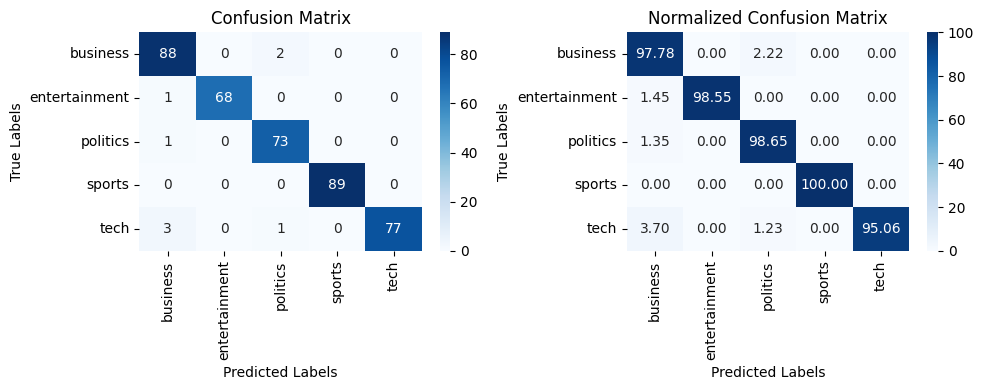

In [30]:
# Confusion matrix
plot_confusion_matrix(y_true_val, y_pred_val, class_names)

### Test evaluation

In [175]:
# Load best model
model = AutoModelForSequenceClassification.from_pretrained(models_path + "best_model")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [176]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_test.extend(torch.argmax(outputs.logits, dim=-1).tolist())
        y_true_test.extend(batch["labels"].tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)
print(y_pred_test.shape, y_true_test.shape)

print(classification_report(y_true_test, y_pred_test, target_names=class_names))

(210,) (210,)
               precision    recall  f1-score   support

     business       0.98      0.98      0.98        50
entertainment       1.00      0.97      0.98        30
     politics       0.98      1.00      0.99        40
       sports       1.00      1.00      1.00        50
         tech       1.00      1.00      1.00        40

     accuracy                           0.99       210
    macro avg       0.99      0.99      0.99       210
 weighted avg       0.99      0.99      0.99       210



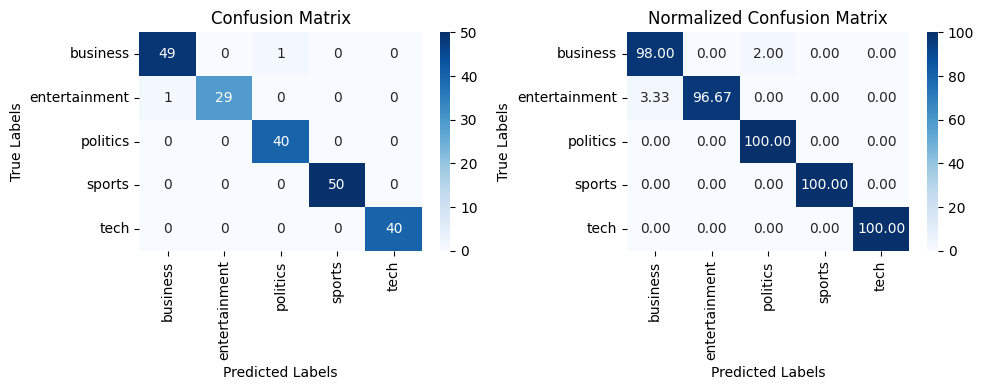

In [177]:
# Confusion matrix
plot_confusion_matrix(y_true_test, y_pred_test, class_names)